# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# View Table Names
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [3]:
# View Table Columns
print('MEASUREMENT')
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

print()
print('STATION')
columns2 = inspector.get_columns("station")
for c in columns2:
    print(c["name"], c["type"])

MEASUREMENT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

STATION
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [4]:
query_measurement = """
                    SELECT
                        *
                    FROM
                        measurement
                    """

query_station = """
                SELECT
                    *
                FROM
                    station
                """

In [5]:
# Save references to each table
conn = engine.connect()
df_measurement = pd.read_sql(query_measurement, con=conn)
df_station = pd.read_sql(query_station, con=conn)
conn.close()

## View Tables

#### Measurement

In [6]:
df_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


#### Station

In [7]:
df_station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

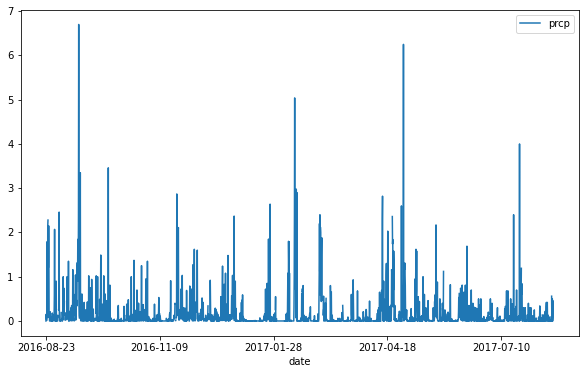

In [8]:
# Query to retrieve the last 12 months of precipitation data and plot the results
query = """
        SELECT
            date,
            prcp,
            station
        FROM
            measurement
        WHERE
            date >= (
                        SELECT
                            date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """


# Save the query results as a Pandas DataFrame
conn = engine.connect()
df_prcpYear = pd.read_sql(query, con=conn)
conn.close()

df_prcpYear.set_index('date').plot(figsize=(10,6), legend=True)

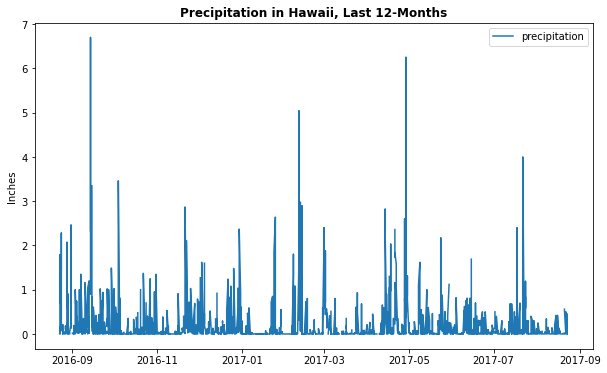

In [9]:
# Sort the dataframe by date

df_sub = df_prcpYear.sort_values('date')
df_sub.date = pd.to_datetime(df_sub.date)

# Plot data
plt.figure(figsize=(10,6))
plt.plot(df_sub.date, df_sub.prcp, label="precipitation")

plt.title("Precipitation in Hawaii, Last 12-Months", fontweight='bold')
plt.xlabel("")
plt.ylabel("Inches")

plt.legend()
plt.show()

In [10]:
# Summary Statistics

df_sub.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [11]:
# Number of station available in the dataset
query = """
        SELECT
            COUNT(*) AS station_count
        FROM
            station
        """

conn = engine.connect()
df_stationCount = pd.read_sql(query, con=conn)
conn.close()

df_stationCount

,station_count
0,9


In [12]:
# Most active stations query
query = """
    SELECT
        s.station,
        count(*) as totalObservations
    FROM
        station s
        JOIN measurement m on s.station = m.station
    GROUP BY 
        s.station
    ORDER BY
        count(*) desc
    """
conn = engine.connect()
df_totObs = pd.read_sql(query, con=conn)
conn.close()

df_totObs

,station,totalObservations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [13]:
# Using the most active station id, get summary statistics.

query = """
        SELECT
            min(tobs) as Min_Temperature,
            max(tobs) as Max_Temperature,
            avg(tobs) as Avg_Temperature
        FROM
            measurement
        WHERE
            station = 'USC00519281'
        """

conn = engine.connect()
df_mostActive = pd.read_sql(query, con=conn)
conn.close()

df_mostActive

,Min_Temperature,Max_Temperature,Avg_Temperature
0,54.0,85.0,71.663781


In [14]:
# Choose the station with the highest number of temperature observations.
activeStation = df_totObs.station[0]


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
        SELECT
            m.date,
            m.prcp,
            m.tobs,
            s.station,
            s.name
        FROM
            measurement m
            JOIN station s on m.station = s.station
        WHERE
            date >= (
                        SELECT
                            date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """
conn = engine.connect()
df_activeStation = pd.read_sql(query, con=conn)
conn.close()

df_hist = df_activeStation.loc[df_activeStation.station == activeStation, "tobs"].reset_index(drop=True)

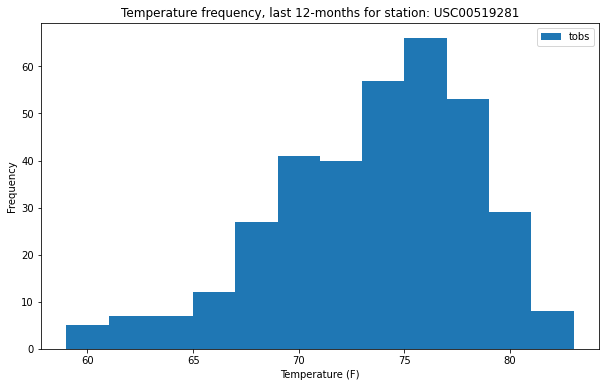

In [15]:
plt.figure(figsize = (10,6))

plt.hist(df_hist, bins=12, label='tobs')

plt.title(f"Temperature frequency, last 12-months for station: {activeStation}")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")

plt.legend()

plt.show()